This code processes and ecosystem service valuation data with KNDVI, and precipitation with CHIRPS.

Created on Tue January 21 2025:
@author: Pius N.Nwachukwu

In [ ]:
!pip install eemont
!pip install wxee
!pip install earthengine-api

In [7]:
import ee, eemont, wxee, pandas as pd


In [3]:
# Authenticate and initialize the Earth Engine module.
ee.Authenticate()
ee.Initialize(project='ee-')

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Dynamic ESV Estimation Using KNDVI Trends

In [8]:
# Load the datasets individually
ndvi_df = pd.read_csv('/content/drive/My Drive/NDVI_Time_Series_With_Country_Continent25.csv')
chirps_df = pd.read_csv('/content/drive/My Drive/CHIRPS_exports/CHIRPS_Monthly_TimeSeries_Fixed.csv')
esv_df = pd.read_csv('/content/drive/My Drive/Esvd_Full_Data_Version_MAY2023V1.1.csv')

# Confirm column names for each dataset
print("NDVI Dataset Columns:")
print(ndvi_df.columns)

print("\nCHIRPS Dataset Columns:")
print(chirps_df.columns)

print("\nESV Dataset Columns:")
print(esv_df.columns)


NDVI Dataset Columns:
Index(['system:index', 'Continent', 'Country', 'Latitude', 'Longitude', 'date',
       'mean', '.geo', 'NDVI_Ref', 'KNDVI'],
      dtype='object')

CHIRPS Dataset Columns:
Index(['system:index', 'Continent', 'Countries', 'Latitude', 'Longitude',
       'date', 'mean', '.geo'],
      dtype='object')

ESV Dataset Columns:
Index(['ValueId', 'StudyId', 'ESVD2.0_Biome', 'ESVD2.0_Biome_Codes',
       'ESVD2.0_Biome_1', 'ESVD2.0_Biome_2', 'ESVD2.0_Biome_3',
       'ESVD2.0_Biome_4', 'ESVD2.0_Biome_5', 'ESVD2.0_Biome_6',
       ...
       'Type Of Beneficiary', 'Int$ Per Hectare Per Year', 'Authors', 'Title',
       'Reference', 'Year_Pub', 'Notes', 'Secondary Data Sources', 'Reviewed',
       'inclExcl'],
      dtype='object', length=122)


In [9]:
# Clean and prepare the Data
# Drop 'Countries' from CHIRPS dataset and 'Country' from NDVI dataset
ndvi_df.drop(columns=['Country'], inplace=True, errors='ignore')
chirps_df.drop(columns=['Countries'], inplace=True, errors='ignore')

# Confirm the changes by displaying the columns
print("NDVI Dataset Columns After Dropping Country:")
print(ndvi_df.columns)

print("\nCHIRPS Dataset Columns After Dropping Countries:")
print(chirps_df.columns)

NDVI Dataset Columns After Dropping Country:
Index(['system:index', 'Continent', 'Latitude', 'Longitude', 'date', 'mean',
       '.geo', 'NDVI_Ref', 'KNDVI'],
      dtype='object')

CHIRPS Dataset Columns After Dropping Countries:
Index(['system:index', 'Continent', 'Latitude', 'Longitude', 'date', 'mean',
       '.geo'],
      dtype='object')


In [10]:
# Conver the date columns to datetime and extract the years

# Convert date columns to datetime format
ndvi_df['date'] = pd.to_datetime(ndvi_df['date'], errors='coerce')
chirps_df['date'] = pd.to_datetime(chirps_df['date'], errors='coerce')

# Extract year from the date column
ndvi_df['year'] = ndvi_df['date'].dt.year
chirps_df['year'] = chirps_df['date'].dt.year

# Confirm the new column has been added correctly
print("NDVI Dataset After Adding Year Column:")
print(ndvi_df[['date', 'year']].head())

print("\nCHIRPS Dataset After Adding Year Column:")
print(chirps_df[['date', 'year']].head())

NDVI Dataset After Adding Year Column:
        date  year
0 2000-02-01  2000
1 2000-02-01  2000
2 2000-02-01  2000
3 2000-02-01  2000
4 2000-02-01  2000

CHIRPS Dataset After Adding Year Column:
        date  year
0 2000-01-01  2000
1 2000-01-01  2000
2 2000-01-01  2000
3 2000-01-01  2000
4 2000-01-01  2000


In [11]:
# Filter the datasets to keep records from 2000 to 2024
ndvi_df = ndvi_df[(ndvi_df['year'] >= 2000) & (ndvi_df['year'] <= 2024)]
chirps_df = chirps_df[(chirps_df['year'] >= 2000) & (chirps_df['year'] <= 2024)]

# Confirm the filtering
print("NDVI Dataset Unique Years After Filtering:")
print(ndvi_df['year'].unique())

print("\nCHIRPS Dataset Unique Years After Filtering:")
print(chirps_df['year'].unique())

NDVI Dataset Unique Years After Filtering:
[2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024]

CHIRPS Dataset Unique Years After Filtering:
[2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024]


In [12]:
# Aggregate NDVI data by Continent and year, taking the mean of KNDVI
ndvi_agg = ndvi_df.groupby(['Continent', 'year'])['KNDVI'].mean().reset_index()

# Aggregate CHIRPS data by Continent and year, taking the mean of precipitation values
chirps_agg = chirps_df.groupby(['Continent', 'year'])['mean'].mean().reset_index()

# Rename columns for clarity
chirps_agg.rename(columns={'mean': 'precipitation_mean'}, inplace=True)

# Display results
print("Aggregated NDVI Data:")
print(ndvi_agg.head())

print("\nAggregated CHIRPS Data:")
print(chirps_agg.head())

Aggregated NDVI Data:
  Continent  year     KNDVI
0    Africa  2000  0.752069
1    Africa  2001  0.758075
2    Africa  2002  0.758006
3    Africa  2003  0.758224
4    Africa  2004  0.764589

Aggregated CHIRPS Data:
  Continent  year  precipitation_mean
0    Africa  2000           86.841330
1    Africa  2001           97.497208
2    Africa  2002          103.734505
3    Africa  2003           94.661875
4    Africa  2004           95.382422


In [13]:
# Here's the code to prepare the ESV dataset:

# Rename 'Value Year' to 'year' for consistency
esv_df.rename(columns={'Value Year': 'year'}, inplace=True)

# Convert 'year' column to integer and filter the data
esv_df['year'] = pd.to_numeric(esv_df['year'], errors='coerce')
esv_df = esv_df[(esv_df['year'] >= 2000) & (esv_df['year'] <= 2024)]

# Select only relevant columns for analysis
esv_selected = esv_df[['Continent', 'year', 'ESVD2.0_Biome', 'Int$ Per Hectare Per Year']]

# Rename the value column for clarity
esv_selected.rename(columns={'Int$ Per Hectare Per Year': 'esv_value'}, inplace=True)

# Display the first few rows of the cleaned ESV dataset
print("Prepared ESV Data:")
print(esv_selected.head())

Prepared ESV Data:
  Continent  year                                      ESVD2.0_Biome  \
0    Europe  2007  Temperate forests and woodlands; Rivers and la...   
1    Europe  2007  Temperate forests and woodlands; Rivers and lakes   
2    Europe  2007                    Temperate forests and woodlands   
3    Europe  2007  Temperate forests and woodlands; Rivers and la...   
4    Europe  2007  Temperate forests and woodlands; Rivers and lakes   

   esv_value  
0   592.8582  
1   822.3934  
2   490.8997  
3   316.1254  
4   489.6888  


<ipython-input-13-edde8c8fc4d7>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  esv_selected.rename(columns={'Int$ Per Hectare Per Year': 'esv_value'}, inplace=True)


In [14]:
# Here’s the code to perform the merge:

# Merge NDVI and CHIRPS data on Continent and year
ndvi_chirps_merged = pd.merge(ndvi_agg, chirps_agg, on=['Continent', 'year'], how='inner')

# Merge the combined NDVI-CHIRPS dataset with ESV dataset
final_merged_df = pd.merge(ndvi_chirps_merged, esv_selected, on=['Continent', 'year'], how='inner')

# Display the first few rows of the merged dataset
print("Final Merged Dataset:")
print(final_merged_df.head())

# Check the shape to confirm number of records
print("\nFinal Merged Dataset Shape:", final_merged_df.shape)

Final Merged Dataset:
  Continent  year     KNDVI  precipitation_mean  \
0    Africa  2000  0.752069            86.84133   
1    Africa  2000  0.752069            86.84133   
2    Africa  2000  0.752069            86.84133   
3    Africa  2000  0.752069            86.84133   
4    Africa  2000  0.752069            86.84133   

                                       ESVD2.0_Biome  esv_value  
0  Tropical and subtropical forests; Coastal systems     0.0737  
1                   Tropical and subtropical forests     0.7052  
2  Tropical and subtropical forests; Coastal systems     1.2036  
3  Tropical and subtropical forests; Coastal systems     1.6879  
4                   Tropical and subtropical forests     0.0643  

Final Merged Dataset Shape: (2543, 6)


In [15]:
# Display summary statistics for numerical columns
print("Summary Statistics:\n")
print(final_merged_df.describe())

# Check for missing values
print("\nMissing Values:\n")
print(final_merged_df.isnull().sum())

Summary Statistics:

              year        KNDVI  precipitation_mean     esv_value
count  2543.000000  2543.000000         2543.000000  1.915000e+03
mean   2012.436492     0.799630          123.810543  1.137219e+04
std       5.748174     0.031976           51.719065  8.277827e+04
min    2000.000000     0.749103           59.519173  0.000000e+00
25%    2009.000000     0.777621           72.905512  8.495250e+00
50%    2013.000000     0.783718          109.193538  9.097360e+01
75%    2018.000000     0.824156          174.065183  5.329422e+02
max    2022.000000     0.891821          251.479172  1.988708e+06

Missing Values:

Continent               0
year                    0
KNDVI                   0
precipitation_mean      0
ESVD2.0_Biome           0
esv_value             628
dtype: int64


<Figure size 1200x600 with 0 Axes>

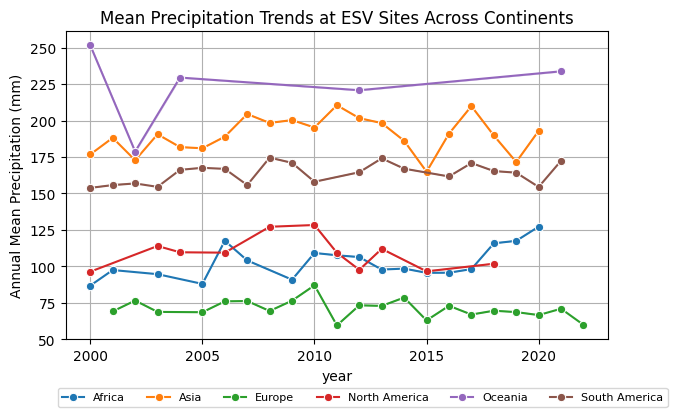

In [18]:
# Trends Over Time
# Plot trends over time

import seaborn as sns

plt.figure(figsize=(12, 6))

# # KNDVI trend
# sns.lineplot(x='year', y='KNDVI', hue='Continent', data=final_merged_df, marker='o')
# plt.title('KNDVI Trends Over Time')
# plt.grid(True)
# plt.show()

# Precipitation trend
plt.figure(figsize=(7, 4))
sns.lineplot(x='year', y='precipitation_mean', hue='Continent', data=final_merged_df, marker='o')
plt.title('Mean Precipitation Trends at ESV Sites Across Continents')
# Set the y-axis label
plt.ylabel('Annual Mean Precipitation (mm)')
plt.grid(True)
plt.legend(loc='upper left', bbox_to_anchor=(-0.025, -0.14), ncol=6, fontsize=8)
plt.show()


# Analyse how each ESV feature has increased or decreased over time across continents, we will perform the following steps:

In [ ]:
# Step 1: Aggregate Data by Continent and Year

# Select relevant features and continent information
top_features = ['Continent', 'year', 'esv_value_lag1', 'precipitation_trend',
                'ESVD2.0_Biome_Temperate forests and woodlands',
                'ESVD2.0_Biome_Rivers and lakes; Rangelands, natural grasslands and savannas',
                'KNDVI_trend']

# Group data by continent and year, then compute mean values
continent_trends = final_merged_df[top_features].groupby(['Continent', 'year']).mean().reset_index()

# Display the aggregated data
print("Aggregated ESV Feature Trends by Continent and Year:")
print(continent_trends.head())


In [ ]:
# Step 2: Calculate Year-over-Year Percentage Change

# Calculate percentage change for each feature within each continent
continent_trends_pct_change = continent_trends.groupby('Continent').apply(lambda x: x.set_index('year').pct_change().reset_index())

# Remove NaN values created due to first difference calculation
continent_trends_pct_change.dropna(inplace=True)

# Display the percentage change data
print("Year-over-Year Percentage Change of ESV Features by Continent:")
print(continent_trends_pct_change.head())

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Plot trends for each feature by continent
# features_to_plot = ['esv_value_lag1', 'precipitation_trend',
#                     'ESVD2.0_Biome_Temperate forests and woodlands',
#                     'ESVD2.0_Biome_Rivers and lakes; Rangelands, natural grasslands and savannas',
#                     'KNDVI_trend']

# plt.figure(figsize=(12, 8))

# for feature in features_to_plot:
#     sns.lineplot(data=continent_trends, x='year', y=feature, hue='Continent', marker='o')
#     plt.title(f'Trend of {feature} Across Continents')
#     plt.xlabel('Year')
#     plt.ylabel('Feature Value')
#     plt.legend(title='Continent')
#     plt.grid()
#     plt.show()


In [49]:
# Step 1: Aggregate Data by Continent and Year

# Check available columns in esv_df
print(esv_df.columns)

# Select relevant columns for analysis
esv_features = ['Continent', 'year', 'Int$ Per Hectare Per Year'] # Changed 'Value Year' to 'year'

# Group data by continent and year, then compute mean values
continent_esv_trends = esv_df[esv_features].groupby(['Continent', 'year']).mean().reset_index() # Changed 'Value Year' to 'year'

# Rename columns for clarity
continent_esv_trends.rename(columns={'year': 'year', 'Int$ Per Hectare Per Year': 'esv_value'}, inplace=True)

# Display the aggregated data
print("Aggregated ESV Trends by Continent and Year:")
print(continent_esv_trends.head())

Index(['ValueId', 'StudyId', 'ESVD2.0_Biome', 'ESVD2.0_Biome_Codes',
       'ESVD2.0_Biome_1', 'ESVD2.0_Biome_2', 'ESVD2.0_Biome_3',
       'ESVD2.0_Biome_4', 'ESVD2.0_Biome_5', 'ESVD2.0_Biome_6',
       ...
       'Type Of Beneficiary', 'Int$ Per Hectare Per Year', 'Authors', 'Title',
       'Reference', 'Year_Pub', 'Notes', 'Secondary Data Sources', 'Reviewed',
       'inclExcl'],
      dtype='object', length=122)
Aggregated ESV Trends by Continent and Year:
  Continent  year   esv_value
0    Africa  2000    0.419660
1    Africa  2001    9.243441
2    Africa  2003  229.074300
3    Africa  2005         NaN
4    Africa  2006  217.471680


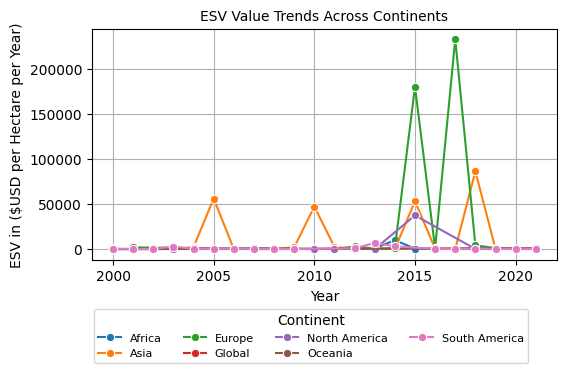

In [52]:
# Step 3: Visualize ESV Trends Across Continents

import matplotlib.pyplot as plt
import seaborn as sns

# Plot ESV trends by continent over time
plt.figure(figsize=(6, 3))
sns.lineplot(data=continent_esv_trends, x='year', y='esv_value', hue='Continent', marker='o')
plt.title('ESV Value Trends Across Continents', fontsize=10)
plt.xlabel('Year')
plt.ylabel('ESV in ($USD per Hectare per Year)')
plt.legend(title='Continent', loc='upper right',bbox_to_anchor=(0.95, -0.19), ncol=4, fontsize=8)
plt.grid()
plt.show()

In [50]:
# Calculate percentage change for each continent
continent_esv_trends_pct_change = continent_esv_trends.groupby('Continent').apply(lambda x: x.set_index('year').pct_change().reset_index())

# Remove NaN values created due to first difference calculation
continent_esv_trends_pct_change.dropna(inplace=True)

# Display the percentage change data
print("Year-over-Year Percentage Change of ESV by Continent:")
print(continent_esv_trends_pct_change.head())


Year-over-Year Percentage Change of ESV by Continent:
             year  esv_value
Continent                   
Africa    1  2001  21.026024
          2  2003  23.782361
          3  2005   0.000000
          4  2006  -0.050650
          5  2007  -0.995063


<ipython-input-50-a2f7e8861b4b>:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  continent_esv_trends_pct_change = continent_esv_trends.groupby('Continent').apply(lambda x: x.set_index('year').pct_change().reset_index())
<ipython-input-50-a2f7e8861b4b>:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  continent_esv_trends_pct_change = continent_esv_trends.groupby('Continent').apply(lambda x: x.set_index('year').pct_change().reset_index())
<ipython-input-50-a2f7e8861b4b>:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future vers

# Code provided in ths section analysed the ESV Valuation by Biome Type

Biome Valuation Rankings (Total ESV Value):
ESVD2.0_Biome
Temperate forests and woodlands                                                                                                                                                 1.854632e+07
Rivers and lakes; Rangelands, natural grasslands and savannas                                                                                                                   1.630420e+06
Rangelands, natural grasslands and savannas; Shrublands and shrubby woodlands; Intensive land use                                                                               6.826177e+05
Tropical and subtropical forests                                                                                                                                                2.904715e+05
Intensive land use                                                                                                                                                              1.275591e+

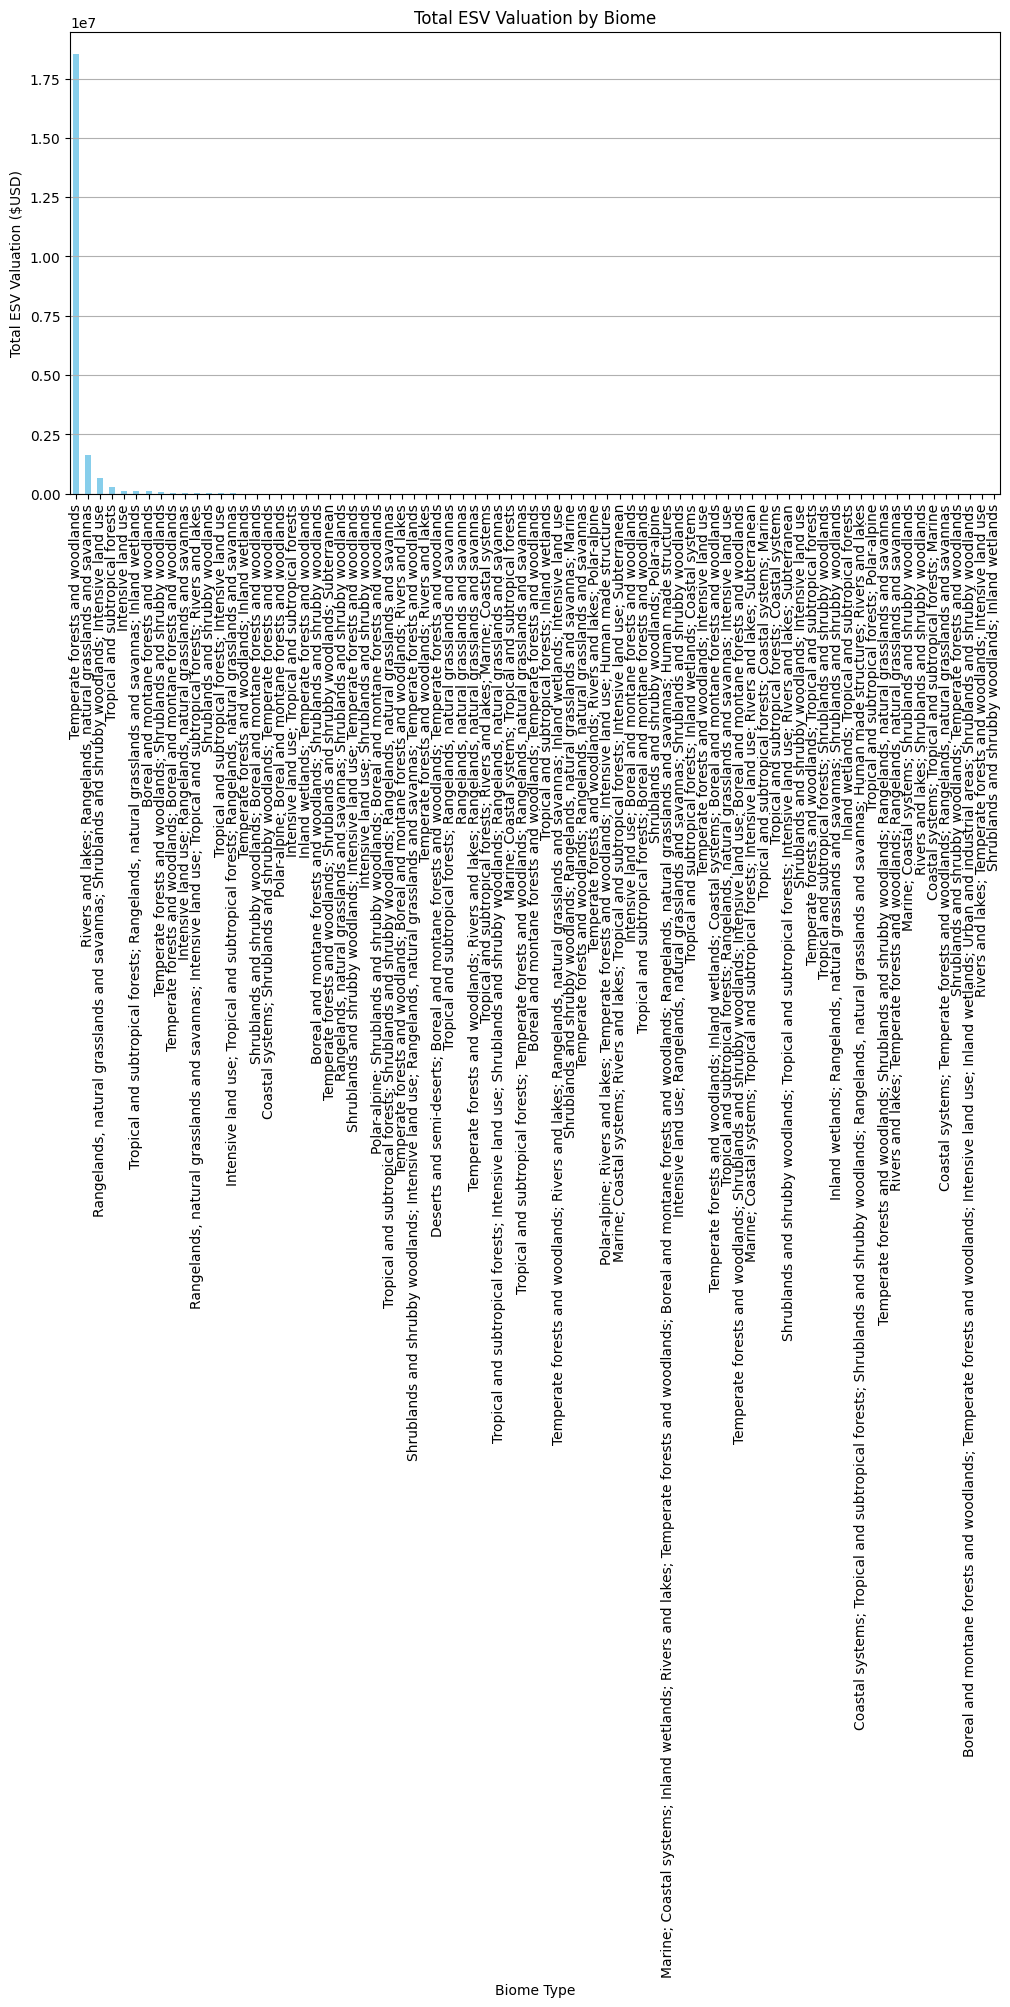

In [19]:
# Group data by biome and calculate the total valuation
biome_valuation = final_merged_df.groupby('ESVD2.0_Biome')['esv_value'].sum().sort_values(ascending=False)

# Display the top biome with the highest valuation
print("Biome Valuation Rankings (Total ESV Value):")
print(biome_valuation)

# Plot the biome valuations
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
biome_valuation.plot(kind='bar', color='skyblue')
plt.title('Total ESV Valuation by Biome')
plt.xlabel('Biome Type')
plt.ylabel('Total ESV Valuation ($USD)')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.show()


In [22]:
# Check for spaces in column names
final_merged_df.columns = final_merged_df.columns.str.strip()

# Try the corrected column name
if 'ESVD2.0_Biome' in final_merged_df.columns:
    biome_valuation = final_merged_df.groupby('ESVD2.0_Biome')['esv_value'].sum().sort_values(ascending=False)
    print("Biome Valuation Rankings (Total ESV Value):")
    print(biome_valuation)
else:
    print("Column 'ESVD2.0_Biome' not found, check column names.")


Biome Valuation Rankings (Total ESV Value):
ESVD2.0_Biome
Temperate forests and woodlands                                                                                                                                                 1.854632e+07
Rivers and lakes; Rangelands, natural grasslands and savannas                                                                                                                   1.630420e+06
Rangelands, natural grasslands and savannas; Shrublands and shrubby woodlands; Intensive land use                                                                               6.826177e+05
Tropical and subtropical forests                                                                                                                                                2.904715e+05
Intensive land use                                                                                                                                                              1.275591e+

Biome Valuation Rankings (Total ESV Value):
ESVD2.0_Biome
Temperate forests and woodlands                                                                                                                                                 1.854632e+07
Rivers and lakes; Rangelands, natural grasslands and savannas                                                                                                                   1.630420e+06
Rangelands, natural grasslands and savannas; Shrublands and shrubby woodlands; Intensive land use                                                                               6.826177e+05
Tropical and subtropical forests                                                                                                                                                2.904715e+05
Intensive land use                                                                                                                                                              1.275591e+

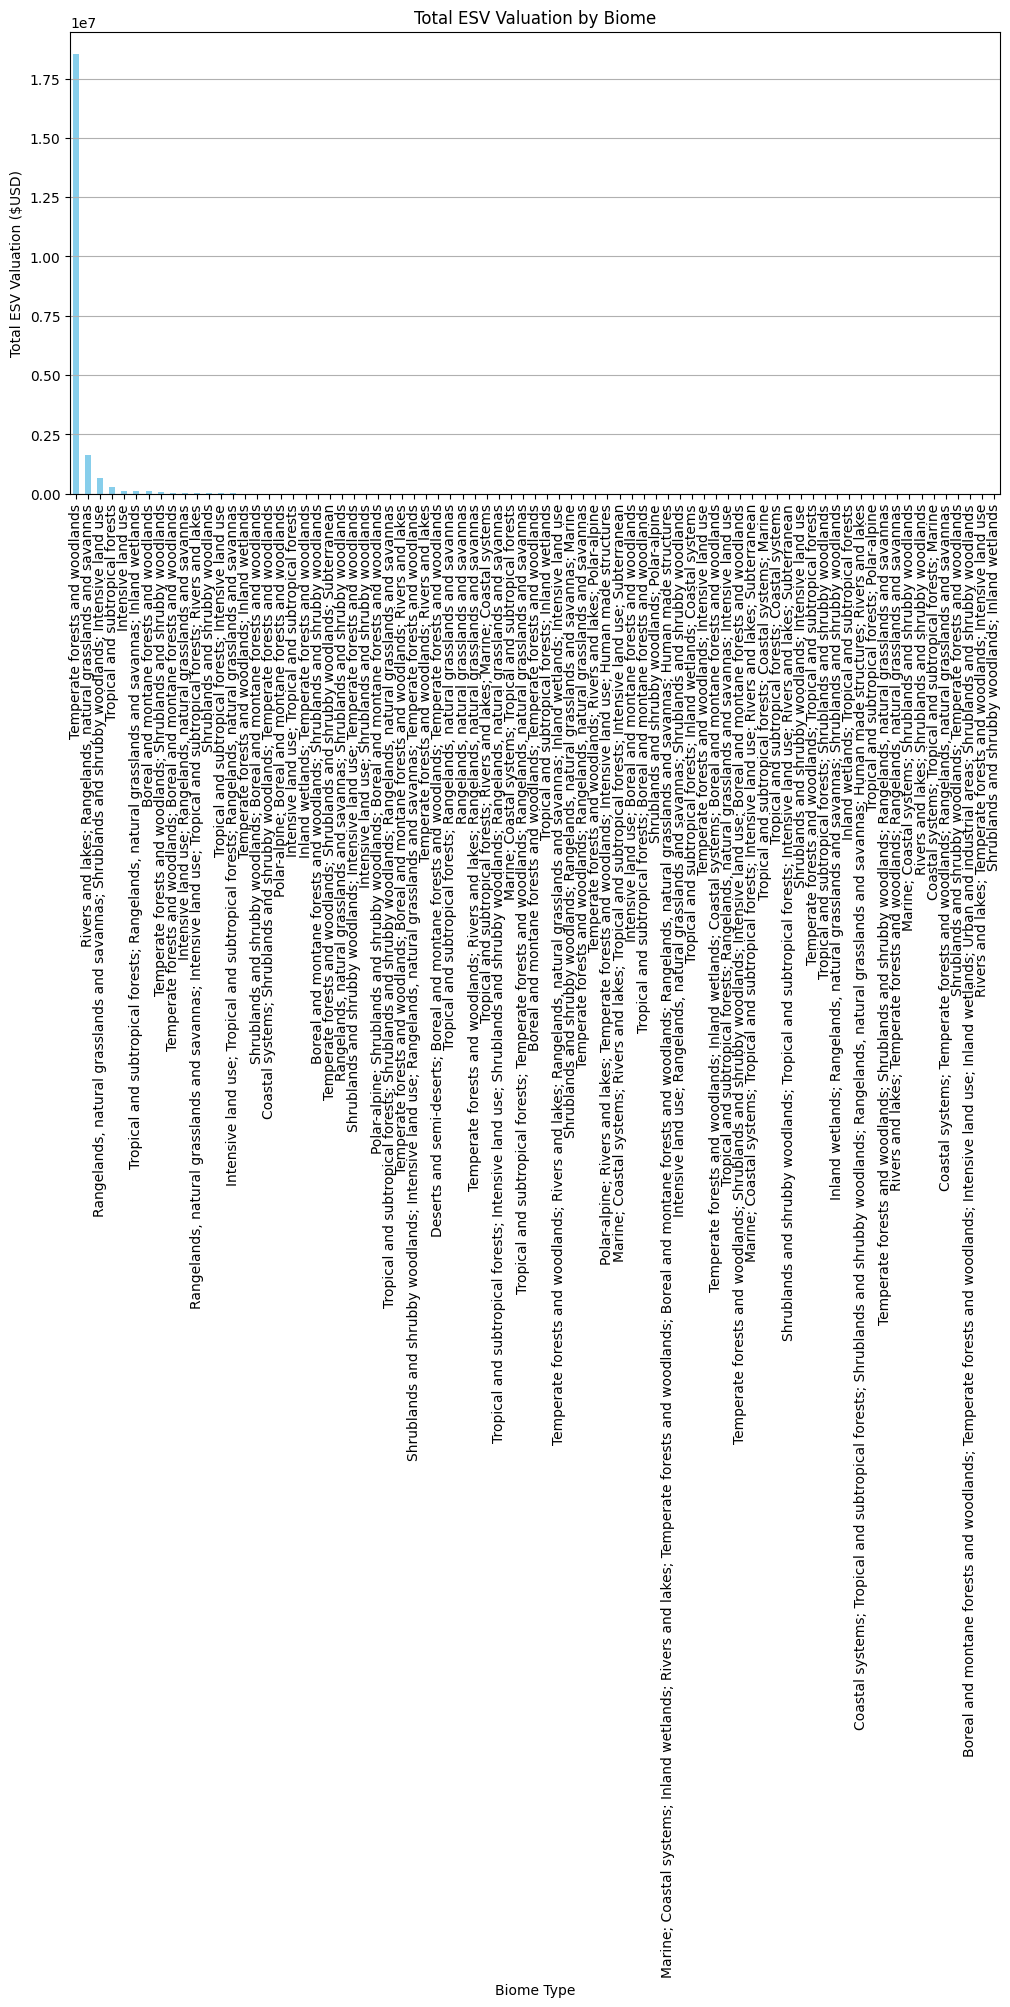

In [25]:
# Select the 'ESVD2.0_Biome' column
biome_column = 'ESVD2.0_Biome'

# Group by biome and calculate total valuation
biome_valuation = final_merged_df.groupby(biome_column)['esv_value'].sum().sort_values(ascending=False)

# Display results
print("Biome Valuation Rankings (Total ESV Value):")
print(biome_valuation)

# Visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
biome_valuation.plot(kind='bar', color='skyblue')
plt.title('Total ESV Valuation by Biome')
plt.xlabel('Biome Type')
plt.ylabel('Total ESV Valuation ($USD)')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.show()

# Steps for Dynamic ESV Estimation:

In [27]:
# Step 1: Data Preparation

from sklearn.preprocessing import StandardScaler

# Check for missing values
print("Missing values in the dataset:")
print(final_merged_df.isnull().sum())

# Drop rows with missing values
final_merged_df.dropna(inplace=True)

# Select features and target variable
features = ['KNDVI', 'precipitation_mean']
target = 'esv_value'

# Scale the feature values
scaler = StandardScaler()
final_merged_df[features] = scaler.fit_transform(final_merged_df[features])

# Display the cleaned and prepared dataset
print("Prepared Dataset:")
print(final_merged_df.head())


Missing values in the dataset:
Continent               0
year                    0
KNDVI                   0
precipitation_mean      0
ESVD2.0_Biome           0
esv_value             628
dtype: int64
Prepared Dataset:
  Continent  year     KNDVI  precipitation_mean  \
0    Africa  2000 -1.388857           -0.637143   
1    Africa  2000 -1.388857           -0.637143   
2    Africa  2000 -1.388857           -0.637143   
3    Africa  2000 -1.388857           -0.637143   
4    Africa  2000 -1.388857           -0.637143   

                                       ESVD2.0_Biome  esv_value  
0  Tropical and subtropical forests; Coastal systems     0.0737  
1                   Tropical and subtropical forests     0.7052  
2  Tropical and subtropical forests; Coastal systems     1.2036  
3  Tropical and subtropical forests; Coastal systems     1.6879  
4                   Tropical and subtropical forests     0.0643  


In [29]:
# Step 2:Impute missing values with the mean of the column
final_merged_df = final_merged_df.assign(esv_value=final_merged_df['esv_value'].fillna(final_merged_df['esv_value'].mean()))


# Confirm missing values are handled
print("Missing values after imputation:")
print(final_merged_df.isnull().sum())


Missing values after imputation:
Continent             0
year                  0
KNDVI                 0
precipitation_mean    0
ESVD2.0_Biome         0
esv_value             0
dtype: int64


In [30]:
# Step 3: Feature Engineering (This operation Might be removed)

# Calculate year-over-year change in KNDVI and precipitation
final_merged_df['KNDVI_trend'] = final_merged_df.groupby('Continent')['KNDVI'].diff()
final_merged_df['precipitation_trend'] = final_merged_df.groupby('Continent')['precipitation_mean'].diff()

# Fill missing values resulting from diff operation
final_merged_df.fillna(0, inplace=True)

# Display the updated dataset with new features
print(final_merged_df[['Continent', 'year', 'KNDVI', 'KNDVI_trend', 'precipitation_mean', 'precipitation_trend', 'esv_value']].head())


  Continent  year     KNDVI  KNDVI_trend  precipitation_mean  \
0    Africa  2000 -1.388857          0.0           -0.637143   
1    Africa  2000 -1.388857          0.0           -0.637143   
2    Africa  2000 -1.388857          0.0           -0.637143   
3    Africa  2000 -1.388857          0.0           -0.637143   
4    Africa  2000 -1.388857          0.0           -0.637143   

   precipitation_trend  esv_value  
0                  0.0     0.0737  
1                  0.0     0.7052  
2                  0.0     1.2036  
3                  0.0     1.6879  
4                  0.0     0.0643  


In [31]:
# Step 4: Model Training for Dynamic ESV Estimation (Valuation in $)

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Select features and target variable
features = ['KNDVI', 'KNDVI_trend', 'precipitation_mean', 'precipitation_trend']
X = final_merged_df[features]
y = final_merged_df['esv_value']

# Split data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Gradient Boosting model
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate model performance
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Model Performance Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")


Model Performance Metrics:
Mean Absolute Error (MAE): 14684.68
Root Mean Squared Error (RMSE): 86505.78
R² Score: 0.15


# Another Method to Implement Dynamic ESV
Step 1: Introduce Biome-Specific Dummies

In [ ]:
# Step 1: Introduce Biome-Specific Dummies

# Create dummy variables for biome types
final_merged_df = pd.get_dummies(final_merged_df, columns=['ESVD2.0_Biome'], drop_first=True)

# Display updated dataset with biome dummies
print("Dataset after adding biome-specific dummies:")
print(final_merged_df.head())

In [33]:
# Step 2: Include Lagged Values of ESV

# Sort by continent and year for proper lag calculation
final_merged_df.sort_values(by=['Continent', 'year'], inplace=True)

# Add a lagged ESV column (previous year ESV)
final_merged_df['esv_value_lag1'] = final_merged_df.groupby('Continent')['esv_value'].shift(1)

# Fill any NaN values introduced by lagging
final_merged_df['esv_value_lag1'].fillna(0, inplace=True)

# Display updated dataset with lag feature
print("Dataset after adding lagged ESV values:")
print(final_merged_df[['Continent', 'year', 'esv_value', 'esv_value_lag1']].head())

Dataset after adding lagged ESV values:
  Continent  year  esv_value  esv_value_lag1
0    Africa  2000     0.0737          0.0000
1    Africa  2000     0.7052          0.0737
2    Africa  2000     1.2036          0.7052
3    Africa  2000     1.6879          1.2036
4    Africa  2000     0.0643          1.6879


<ipython-input-33-687cead60c95>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  final_merged_df['esv_value_lag1'].fillna(0, inplace=True)


In [34]:
#  check if the lagged values were properly added

# Display dataset with the new lag feature
print(final_merged_df[['Continent', 'year', 'esv_value', 'esv_value_lag1']].head())

  Continent  year  esv_value  esv_value_lag1
0    Africa  2000     0.0737          0.0000
1    Africa  2000     0.7052          0.0737
2    Africa  2000     1.2036          0.7052
3    Africa  2000     1.6879          1.2036
4    Africa  2000     0.0643          1.6879


In [ ]:
# Step 3: Add Polynomial Features

from sklearn.preprocessing import PolynomialFeatures

# Selecting features to expand with polynomial terms
features_to_poly = ['KNDVI', 'precipitation_mean']

# Apply polynomial transformation
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(final_merged_df[features_to_poly])

# Convert to DataFrame and merge with existing data
poly_df = pd.DataFrame(poly_features, columns=poly.get_feature_names_out(features_to_poly))
final_merged_df = pd.concat([final_merged_df.reset_index(drop=True), poly_df], axis=1)

# Display dataset with polynomial features
print("Dataset after adding polynomial features:")
print(final_merged_df.head())

In [36]:
# Run the Updated Model Training Code:


from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Selecting relevant features for modeling
feature_columns = [col for col in final_merged_df.columns if col not in ['Continent', 'year', 'esv_value']]
X = final_merged_df[feature_columns]
y = final_merged_df['esv_value']

# Split the dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Gradient Boosting model with updated features
model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=4, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate model performance
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Updated Model Performance Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")


Updated Model Performance Metrics:
Mean Absolute Error (MAE): 8612.08
Root Mean Squared Error (RMSE): 78489.05
R² Score: 0.30


# Next Steps to Further Improve Performance:

Step 1: Hyperparameter Tuning

In [37]:
# Code for Hyperparameter Tuning using GridSearchCV

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of boosting stages
    'learning_rate': [0.01, 0.05, 0.1],  # Learning rate to shrink contribution of each tree
    'max_depth': [3, 5, 7],  # Maximum depth of each tree
    'subsample': [0.8, 1.0],  # Fraction of samples used to grow each tree
    'min_samples_split': [2, 5, 10]  # Minimum samples to split an internal node
}

# Initialize the model
gb_model = GradientBoostingRegressor(random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid,
                           cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

# Fit the model to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters from the grid search
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train a new model with the best found parameters
optimized_model = GradientBoostingRegressor(**best_params, random_state=42)
optimized_model.fit(X_train, y_train)

# Make predictions
y_pred_opt = optimized_model.predict(X_test)

# Evaluate performance
mae_opt = mean_absolute_error(y_test, y_pred_opt)
rmse_opt = np.sqrt(mean_squared_error(y_test, y_pred_opt))
r2_opt = r2_score(y_test, y_pred_opt)

print("\nOptimized Model Performance Metrics:")
print(f"Mean Absolute Error (MAE): {mae_opt:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_opt:.2f}")
print(f"R² Score: {r2_opt:.2f}")

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 1.0}

Optimized Model Performance Metrics:
Mean Absolute Error (MAE): 11967.69
Root Mean Squared Error (RMSE): 79204.45
R² Score: 0.29


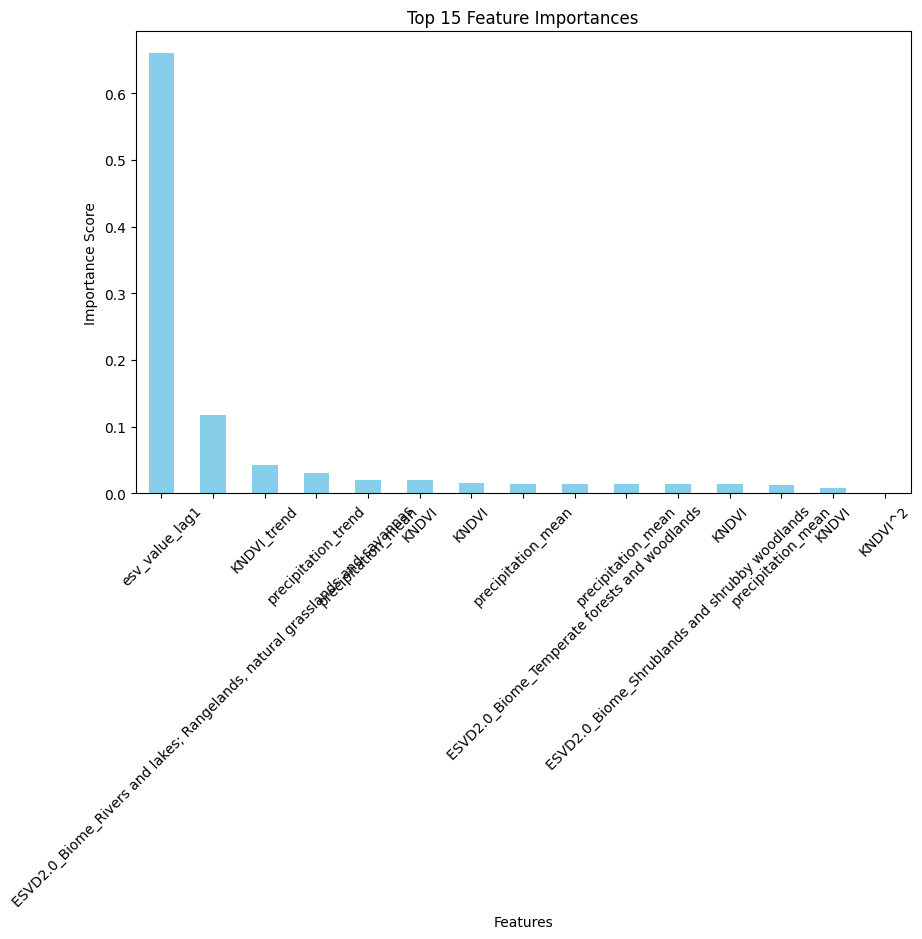

Top 10 Important Features:
esv_value_lag1                                                                 0.659946
ESVD2.0_Biome_Rivers and lakes; Rangelands, natural grasslands and savannas    0.118151
KNDVI_trend                                                                    0.043202
precipitation_trend                                                            0.031240
precipitation_mean                                                             0.020729
KNDVI                                                                          0.019636
KNDVI                                                                          0.014974
precipitation_mean                                                             0.014728
ESVD2.0_Biome_Temperate forests and woodlands                                  0.014414
precipitation_mean                                                             0.014319
dtype: float64


In [38]:
# Step 2: Feature Importance Analysis

import matplotlib.pyplot as plt
import pandas as pd

# Get feature importances from the optimized model
feature_importance = pd.Series(optimized_model.feature_importances_, index=X.columns)

# Sort and plot feature importance
plt.figure(figsize=(10, 6))
feature_importance.sort_values(ascending=False).head(15).plot(kind='bar', color='skyblue')
plt.title('Top 15 Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.xticks(rotation=45)
plt.show()

# Display the top features numerically
print("Top 10 Important Features:")
print(feature_importance.sort_values(ascending=False).head(10))

# Next Steps: Select features from the Biome list and use them for Model Simplification

In [39]:
# Retrain the Model with Selected Features

# Select important features based on feature importance analysis
selected_features = [
    'esv_value_lag1',
    'ESVD2.0_Biome_Rivers and lakes; Rangelands, natural grasslands and savannas',
    'KNDVI_trend',
    'precipitation_trend',
    'ESVD2.0_Biome_Temperate forests and woodlands'
]

X_selected = final_merged_df[selected_features]
y = final_merged_df['esv_value']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Train the model again
optimized_model.fit(X_train, y_train)

# Evaluate model performance with fewer features
y_pred_selected = optimized_model.predict(X_test)

# Calculate evaluation metrics
mae_selected = mean_absolute_error(y_test, y_pred_selected)
rmse_selected = np.sqrt(mean_squared_error(y_test, y_pred_selected))
r2_selected = r2_score(y_test, y_pred_selected)

print("Optimized Model with Selected Features:")
print(f"Mean Absolute Error (MAE): {mae_selected:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_selected:.2f}")
print(f"R² Score: {r2_selected:.2f}")


Optimized Model with Selected Features:
Mean Absolute Error (MAE): 11967.69
Root Mean Squared Error (RMSE): 79204.45
R² Score: 0.29


# Next Steps: Try Advanced Machine Learning Models (Rcmd)


In [40]:
# Step 1: Implement XGBoost Regression

import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Prepare DMatrix for XGBoost (optimized internal data structure)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define XGBoost parameters
xgb_params = {
    'objective': 'reg:squarederror',  # Regression task
    'eval_metric': 'rmse',
    'learning_rate': 0.05,
    'max_depth': 5,
    'n_estimators': 200,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42
}

# Train the XGBoost model
xgb_model = xgb.train(params=xgb_params, dtrain=dtrain, num_boost_round=200)

# Make predictions
y_pred_xgb = xgb_model.predict(dtest)

# Evaluate model performance
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print("XGBoost Model Performance:")
print(f"Mean Absolute Error (MAE): {mae_xgb:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_xgb:.2f}")
print(f"R² Score: {r2_xgb:.2f}")


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:20:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Model Performance:
Mean Absolute Error (MAE): 10192.99
Root Mean Squared Error (RMSE): 81365.21
R² Score: 0.25


# Next Steps: Try with Random Forest
Random Forest Model Implementation:

In [41]:
from sklearn.ensemble import RandomForestRegressor

# Define the Random Forest model with initial hyperparameters
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Model Performance:")
print(f"Mean Absolute Error (MAE): {mae_rf:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_rf:.2f}")
print(f"R² Score: {r2_rf:.2f}")


Random Forest Model Performance:
Mean Absolute Error (MAE): 9359.05
Root Mean Squared Error (RMSE): 78670.28
R² Score: 0.30


# Fine-tune the Random Forest model to improve its performance by optimizing hyperparameters using Grid Search

In [42]:
# Code for Random Forest Hyperparameter Tuning:

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid_rf = {
    'n_estimators': [100, 200, 300],  # Number of trees
    'max_depth': [10, 20, None],  # Max depth of trees
    'min_samples_split': [2, 5, 10],  # Minimum samples to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples required at a leaf node
}

# Initialize the Random Forest model
rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)

# Perform Grid Search with cross-validation
grid_search_rf = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid_rf,
    cv=5,  # 5-fold cross-validation
    scoring='neg_mean_squared_error',
    n_jobs=-1,  # Use all available processors
    verbose=1  # Show progress
)

# Fit the model to the training data
grid_search_rf.fit(X_train, y_train)

# Get the best parameters
best_rf_params = grid_search_rf.best_params_
print("Best Hyperparameters for Random Forest:", best_rf_params)

# Train the final model with the best parameters
optimized_rf_model = RandomForestRegressor(**best_rf_params, random_state=42)
optimized_rf_model.fit(X_train, y_train)

# Make predictions
y_pred_optimized_rf = optimized_rf_model.predict(X_test)

# Evaluate the model performance
mae_rf_opt = mean_absolute_error(y_test, y_pred_optimized_rf)
rmse_rf_opt = np.sqrt(mean_squared_error(y_test, y_pred_optimized_rf))
r2_rf_opt = r2_score(y_test, y_pred_optimized_rf)

print("\nOptimized Random Forest Model Performance:")
print(f"Mean Absolute Error (MAE): {mae_rf_opt:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_rf_opt:.2f}")
print(f"R² Score: {r2_rf_opt:.2f}")


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Hyperparameters for Random Forest: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}

Optimized Random Forest Model Performance:
Mean Absolute Error (MAE): 9992.13
Root Mean Squared Error (RMSE): 79961.70
R² Score: 0.27


# Next Steps: Unsing Ensemble Modeling Approach

In [43]:
!pip install --upgrade xgboost
!pip install --upgrade scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 77.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.0
    Uninstalling scikit-learn-1.6.0:
      Successfully uninstalled scikit-learn-1.6.0


In [44]:
#  Train Random Forest Model
rf_model = RandomForestRegressor(n_estimators=300, max_depth=10, min_samples_split=10, min_samples_leaf=4, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

# Train XGBoost Model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.8, colsample_bytree=0.8, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)



In [45]:
# Step 2: Combine Predictions Using a Meta-Model

from sklearn.linear_model import LinearRegression

# Stack the predictions as new features
stacked_features = np.column_stack((rf_preds, xgb_preds))

# Train a meta-model (Linear Regression) on top of the stacked predictions
meta_model = LinearRegression()
meta_model.fit(stacked_features, y_test)

# Predict final ESV values using the ensemble
final_predictions = meta_model.predict(stacked_features)

# Evaluate the performance of the stacked ensemble model
mae_stacking = mean_absolute_error(y_test, final_predictions)
rmse_stacking = np.sqrt(mean_squared_error(y_test, final_predictions))
r2_stacking = r2_score(y_test, final_predictions)

print("Manual Stacking Ensemble Model Performance:")
print(f"Mean Absolute Error (MAE): {mae_stacking:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_stacking:.2f}")
print(f"R² Score: {r2_stacking:.2f}")


Manual Stacking Ensemble Model Performance:
Mean Absolute Error (MAE): 13411.83
Root Mean Squared Error (RMSE): 79433.37
R² Score: 0.28


# Indept Analysis of the Data to Determine if the Spike is an Outlier:
1. Descriptive Statistics:

In [ ]:
europe_esv = final_merged_df[final_merged_df['Continent'] == 'Europe']['esv_value']
z_scores = (europe_esv - europe_esv.mean()) / europe_esv.std()
outliers = europe_esv[abs(z_scores) > 3]
print(outliers)


1163    3.332007e+05
1164    4.492071e+05
1165    4.260430e+05
1166    3.639820e+05
1167    5.033976e+05
1168    3.872309e+05
1169    5.111406e+05
1170    4.410894e+05
1171    3.403756e+05
1172    4.491832e+05
1174    4.480438e+05
1175    4.453612e+05
1176    4.733303e+05
1177    3.098047e+05
1178    3.330162e+05
1179    4.144728e+05
1180    3.330322e+05
1181    3.175456e+05
1183    3.949972e+05
1184    4.791784e+05
1185    4.646358e+05
1186    5.340785e+05
1187    5.575036e+05
1188    5.345078e+05
1190    4.804331e+05
1191    4.025580e+05
1192    3.484997e+05
1193    3.230576e+05
1194    3.253100e+05
1195    4.723900e+05
1239    1.051330e+06
1243    4.460188e+05
Name: esv_value, dtype: float64


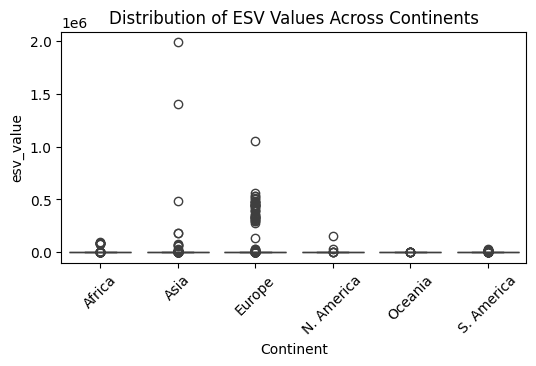

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 3))
sns.boxplot(x='Continent', y='esv_value', data=final_merged_df)
plt.title('Distribution of ESV Values Across Continents')
plt.xticks(rotation=45)
plt.show()


Analysis of the Data for Potential Outliers:

In [ ]:
from scipy.stats import zscore

europe_values = final_merged_df[final_merged_df['Continent'] == 'Europe']['esv_value']
z_scores = zscore(europe_values)
outliers = europe_values[abs(z_scores) > 3]
print("Potential Outliers:", outliers)


Potential Outliers: 1163    3.332007e+05
1164    4.492071e+05
1165    4.260430e+05
1166    3.639820e+05
1167    5.033976e+05
1168    3.872309e+05
1169    5.111406e+05
1170    4.410894e+05
1171    3.403756e+05
1172    4.491832e+05
1174    4.480438e+05
1175    4.453612e+05
1176    4.733303e+05
1177    3.098047e+05
1178    3.330162e+05
1179    4.144728e+05
1180    3.330322e+05
1181    3.175456e+05
1183    3.949972e+05
1184    4.791784e+05
1185    4.646358e+05
1186    5.340785e+05
1187    5.575036e+05
1188    5.345078e+05
1190    4.804331e+05
1191    4.025580e+05
1192    3.484997e+05
1193    3.230576e+05
1194    3.253100e+05
1195    4.723900e+05
1239    1.051330e+06
1243    4.460188e+05
Name: esv_value, dtype: float64


In [ ]:
# Interquartile Range (IQR): Detects outliers based on quartile differences.


Q1 = europe_values.quantile(0.25)
Q3 = europe_values.quantile(0.75)
IQR = Q3 - Q1

outliers = europe_values[(europe_values < (Q1 - 1.5 * IQR)) | (europe_values > (Q3 + 1.5 * IQR))]
print("Outliers using IQR method:", outliers)


Outliers using IQR method: 787     2468.7993
788     3642.4908
789     3399.6581
790     4573.3495
811     2678.9102
          ...    
1544    6324.9355
1546    4326.8044
1548    2676.6712
1549    3735.3366
1550    2455.8942
Name: esv_value, Length: 116, dtype: float64


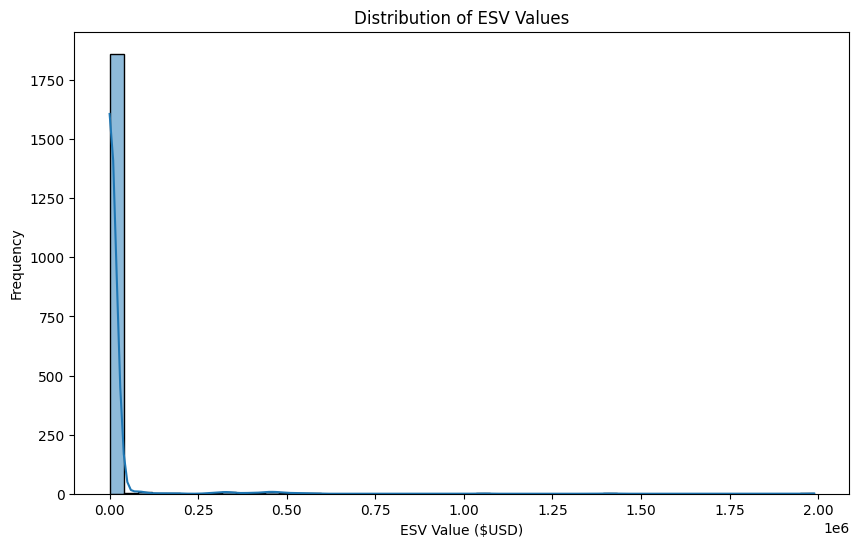

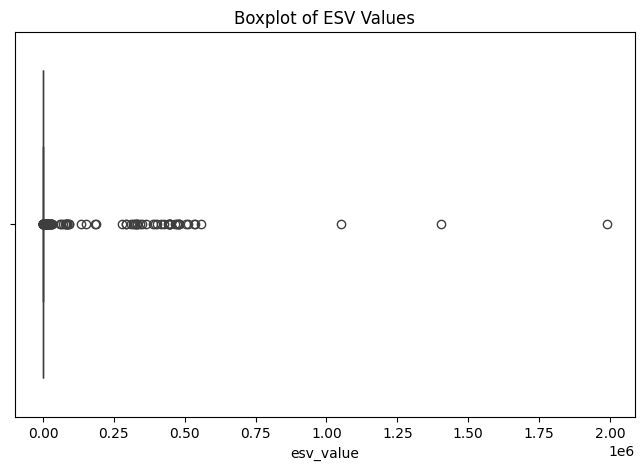

In [53]:
# C. Visualize Distribution of Values
# Using histograms and boxplots to further inspect the data distribution.

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(final_merged_df['esv_value'], bins=50, kde=True)
plt.title('Distribution of ESV Values')
plt.xlabel('ESV Value ($USD)')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(8, 5))
sns.boxplot(x=final_merged_df['esv_value'])
plt.title('Boxplot of ESV Values')
plt.show()


# Analyse KNDVI over Time


Load NDVI Time series

In [ ]:
# Load the KNDVI time series dataset
kndvi_time_series_file_path = '/content/drive/My Drive/NDVI_Time_Series_With_Country_Continent25.csv'
kndvi_time_series_data = pd.read_csv(kndvi_time_series_file_path)

# Inspect the first few rows to understand the structure of the data
kndvi_time_series_data.head()


In [58]:
# Convert the 'date' column to datetime format
kndvi_time_series_data['date'] = pd.to_datetime(kndvi_time_series_data['date'], format='%Y-%m-%d') # Changed format to '%Y-%m-%d'

# Extract year and month for further analysis
kndvi_time_series_data['year'] = kndvi_time_series_data['date'].dt.year
kndvi_time_series_data['month'] = kndvi_time_series_data['date'].dt.month


In [59]:
# Calculate the percentage change per location safely

import matplotlib.pyplot as plt
import numpy as np

# Group by Latitude and Longitude and calculate the first and last KNDVI values per location
first_kndvi = kndvi_time_series_data.groupby(['Latitude', 'Longitude'])['KNDVI'].first()
last_kndvi = kndvi_time_series_data.groupby(['Latitude', 'Longitude'])['KNDVI'].last()

# Merge the first and last values for each location
kndvi_change = pd.DataFrame({
    'Latitude': first_kndvi.index.get_level_values(0),
    'Longitude': first_kndvi.index.get_level_values(1),
    'First_KNDVI': first_kndvi.values,
    'Last_KNDVI': last_kndvi.values
})

# Calculate the percentage change per location safely
kndvi_change['KNDVI_percentage_change'] = ((kndvi_change['Last_KNDVI'] - kndvi_change['First_KNDVI']) /
                                           abs(kndvi_change['First_KNDVI']).replace(0, np.nan)) * 100

# Clip the percentage change values to be within -100% to 100%
kndvi_change['KNDVI_percentage_change'] = kndvi_change['KNDVI_percentage_change'].clip(-100, 100)

# Remove any remaining infinite or NaN values
kndvi_change.replace([np.inf, -np.inf], np.nan, inplace=True)
kndvi_change.dropna(inplace=True)

# Display updated data
kndvi_change.head()


,Latitude,Longitude,First_KNDVI,Last_KNDVI,KNDVI_percentage_change
0,-55.062461,-67.611307,0.67885,0.88455,30.301245
1,-45.408333,-72.800000,0.53365,0.80235,50.351354
2,-43.600000,171.163700,0.76575,0.67325,-12.079660
3,-41.330108,-73.661378,0.77105,0.91510,18.682316
4,-41.141667,-72.173056,0.90165,0.84020,-6.815283


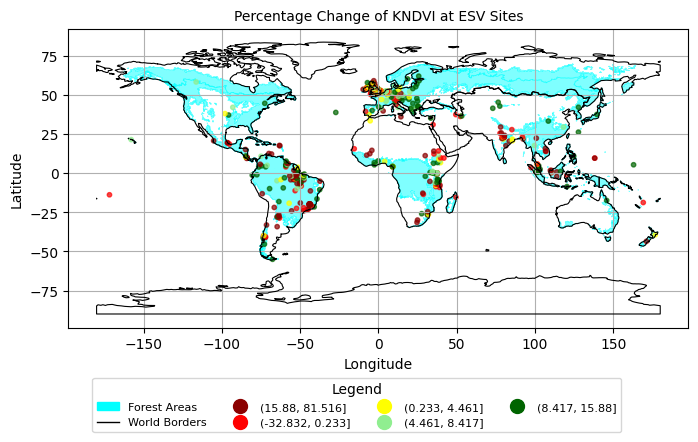

In [60]:
# Complete Plot Code

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.lines as mlines
import matplotlib.patches as mpatches


# Load the shapefiles from Google Drive
world_borders_path = '/content/drive/My Drive/Eco2Adapt_Shapes/natural_Earth/World_Borders_03.shp'
full_ifl_path = '/content/drive/My Drive/Eco2Adapt_Shapes/Forest_zone/forest_zone.shp'

# Read the shapefiles
world_borders = gpd.read_file(world_borders_path)
full_ifl = gpd.read_file(full_ifl_path)

# Categorize KNDVI percentage change into 5 quantile-based bins using actual values
kndvi_change['KNDVI_change_class'] = pd.qcut(
    kndvi_change['KNDVI_percentage_change'],
    q=5,
    duplicates='drop'
)

# Extract class bin ranges for labeling
class_bins = kndvi_change['KNDVI_change_class'].unique()

# Convert the dataset to a GeoDataFrame for spatial plotting
gdf = gpd.GeoDataFrame(
    kndvi_change,
    geometry=gpd.points_from_xy(kndvi_change['Longitude'], kndvi_change['Latitude'])
)

# Define a colormap for the visualization
cmap = ListedColormap(['darkred', 'red', 'yellow', 'lightgreen', 'darkgreen'])

# Plot the data with discrete color classes
fig, ax = plt.subplots(figsize=(8, 5))

# Plot world borders with black boundary lines
world_borders.boundary.plot(ax=ax, color="black", linewidth=0.8, label="World Borders")

# Plot intact forest landscapes with cyan fill
full_ifl.plot(ax=ax, color="cyan", edgecolor="cyan", linewidth=0.5, alpha=0.5, label="Forest Areas")

# Plot KNDVI change data with quantile-based classification
gdf.plot(column='KNDVI_change_class', cmap=cmap, legend=False, markersize=10, alpha=0.7, ax=ax)

# Create legend entries for forest and borders
legend_patches = [
    mpatches.Patch(color="cyan", label="Forest Areas"),
    mlines.Line2D([], [], color="black", linewidth=1, label="World Borders")  # Line representation
]

# Add round markers for KNDVI classes in the legend
for i in range(len(class_bins)):
    legend_patches.append(
        mlines.Line2D([], [], color=cmap(i / len(class_bins)), marker='o', markersize=10, linestyle='None', label=str(class_bins[i]))
    )

# Display the legend on the plot with updated positioning and round markers
ax.legend(handles=legend_patches, title="Legend", loc='upper right', bbox_to_anchor=(0.9, -0.15), ncol=4, fontsize=8)

# Customize plot
plt.title('Percentage Change of KNDVI at ESV Sites', fontsize=10)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)

plt.show()

# KNDVI and ESV Sites (Location)

In [62]:
# Get the first image from the ImageCollection
MOD_collection = ee.ImageCollection("MODIS/006/MCD43A4") \
    .filterDate("2021-06-01","2021-08-02") \
    .scaleAndOffset() \
    .spectralIndices("kNDVI")

single_image_ee = MOD_collection.first()

/usr/local/lib/python3.11/dist-packages/ee/deprecation.py:207: DeprecationWarning: 

Attention required for MODIS/006/MCD43A4! You are using a deprecated asset.
To ensure continued functionality, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MCD43A4

  warnings.warn(warning, category=DeprecationWarning)


Downloading:   0%|          | 0.00/568k [00:00<?, ?iB/s]

<ipython-input-64-f1a26be7a168>:39: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='upper left', bbox_to_anchor=(1, -0.05), ncol=6)


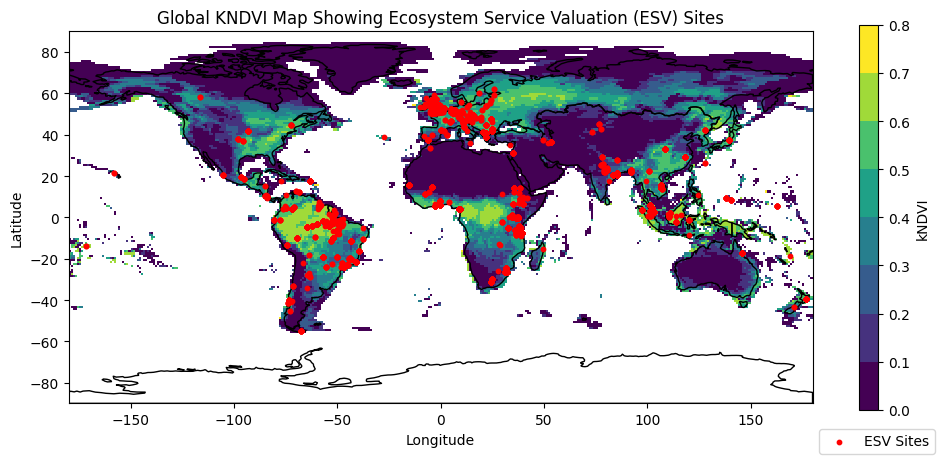

In [64]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# Step 1: Load the CSV data and convert it to a GeoDataFrame
file_path = '/content/drive/My Drive/Esvd_Full_Data_Version_MAY2023V1.1.csv'
esvd_data = pd.read_csv(file_path)

# Assuming the CSV has 'Longitude' and 'Latitude' columns
geometry = [Point(xy) for xy in zip(esvd_data['Longitude'], esvd_data['Latitude'])]
esvd_gdf = gpd.GeoDataFrame(esvd_data, geometry=geometry)

# Step 2: Convert the single Earth Engine image to an xarray Dataset
single_image_xarray = single_image_ee.wx.to_xarray(region=ee.Geometry.BBox(-180, -90, 180, 90))

# Step 3: Read the shapefile
shapefile_path = '/content/drive/My Drive/Eco2Adapt_Shapes/natural_Earth/World_Borders_03.shp'  # Adjust path as needed
world_borders = gpd.read_file(shapefile_path)

# Step 4: Plot the kNDVI
fig, ax = plt.subplots(figsize=(12, 5))
single_image_xarray.kNDVI.plot(
    ax=ax,
    cmap="viridis",
    levels=10,
    # vmin=0,
    # vmax=1,
)

# Step 5: Add the shapefile overlay
world_borders.plot(ax=ax, color='none', edgecolor='black', label='World Borders')
esvd_gdf.plot(ax=ax, color='red', markersize=10, label='ESV Sites')

# Step 6: Customize the plot
ax.set_title("Global KNDVI Map Showing Ecosystem Service Valuation (ESV) Sites")
ax.set_xlabel("Longitude")  # Label for the x-axis
ax.set_ylabel("Latitude")   # Label for the y-axis
ax.legend(loc='upper left', bbox_to_anchor=(1, -0.05), ncol=6)

plt.show()
